# 📊 Analisis Data untuk Dashboard Aktivitas Sales

## 🎯 Tujuan Analisis
Notebook ini menganalisis data aktivitas sales untuk menghasilkan insight yang akan ditampilkan dalam dashboard interaktif. Tujuan utama:
1. Memantau dan mengevaluasi efektivitas aktivitas sales
2. Menghasilkan insight strategis dan operasional
3. Menyediakan dasar rekomendasi improvement yang data-driven

## 📝 Struktur Analisis
1. Import Library dan Data Preparation
2. Overview Aktivitas Sales (High-Level Metrics)
3. Sales Funnel Analysis
4. Analisis Durasi & Frekuensi Kunjungan
5. Performa Individu Sales
6. Detail Profil Sales
7. Analisis Segmentasi Customer
8. Insight & Rekomendasi Generator

## 💾 Output
Hasil analisis akan disimpan dalam format pickle untuk digunakan oleh dashboard Streamlit:
- overview_metrics.pkl
- funnel_analysis.pkl
- durasi_kunjungan.pkl
- performa_sales.pkl
- profil_sales.pkl
- segmentasi.pkl
- rekomendasi.pkl

## 1. Import Library dan Data Preparation

In [22]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pickle

# Set style plotting
sns.set_theme()  # Set seaborn theme
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [10, 6]

# Baca dataset
df = pd.read_csv('sales_visits_finalbgt_enriched.csv')

# Konversi kolom tanggal
df['Tanggal'] = pd.to_datetime(df['Tanggal'])

In [23]:
# Cek kolom yang tersedia di dataset
print("Kolom yang tersedia dalam dataset:")
print(df.columns.tolist())

Kolom yang tersedia dalam dataset:
['ID_Kunjungan', 'ID_Customer', 'Tanggal', 'Nama_Sales', 'Level_Sales', 'Nilai_Kontrak', 'Target_Sales', 'Segmen', 'Target_Segmen', 'Jenis_Kunjungan', 'Nama_Customer', 'Status_Customer', 'Status_Kontrak', 'Catatan', 'Kunjungan_Ke', 'Progress']


## 2. Overview Aktivitas Sales (High-Level Metrics)

Bagian ini menganalisis metrik tingkat tinggi untuk memberikan gambaran umum aktivitas sales, meliputi:
- Total Customer Aktif
- Total Kunjungan
- Total Nilai Kontrak
- Status Deal/Potensi Deal
- Distribusi Segmen
- Jumlah Kunjungan per Tahap

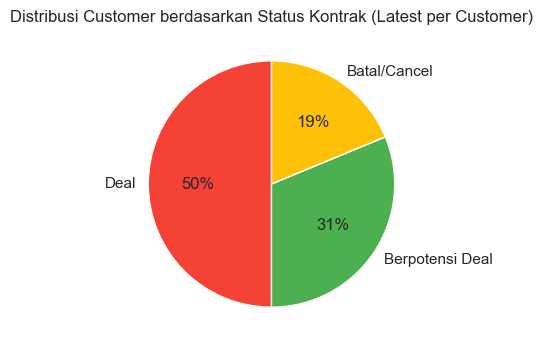

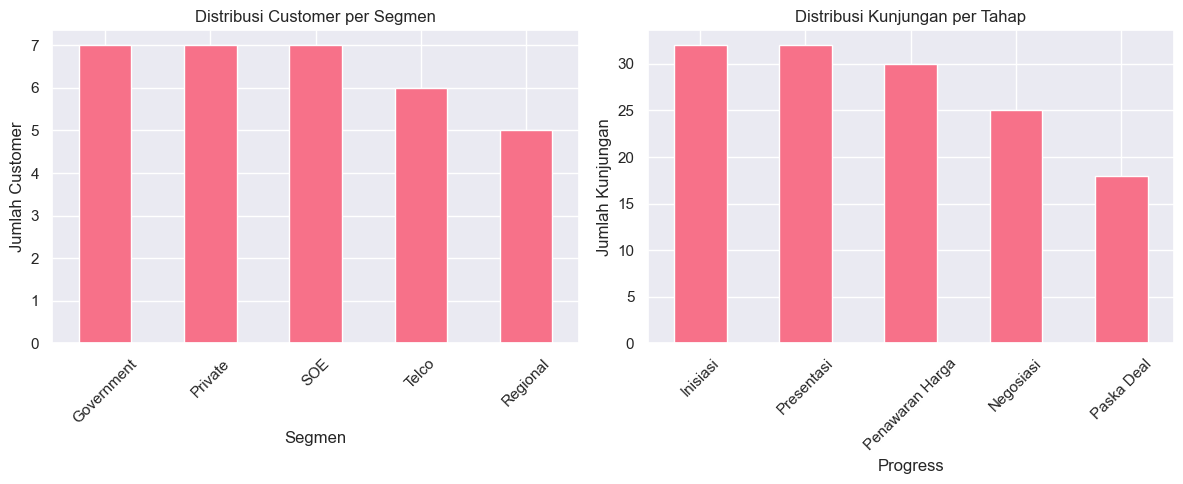


Ringkasan Metrik Tingkat Tinggi:
Total Customer Aktif: 32
Total Kunjungan: 137
Total Nilai Kontrak: Rp 14,177,000,000


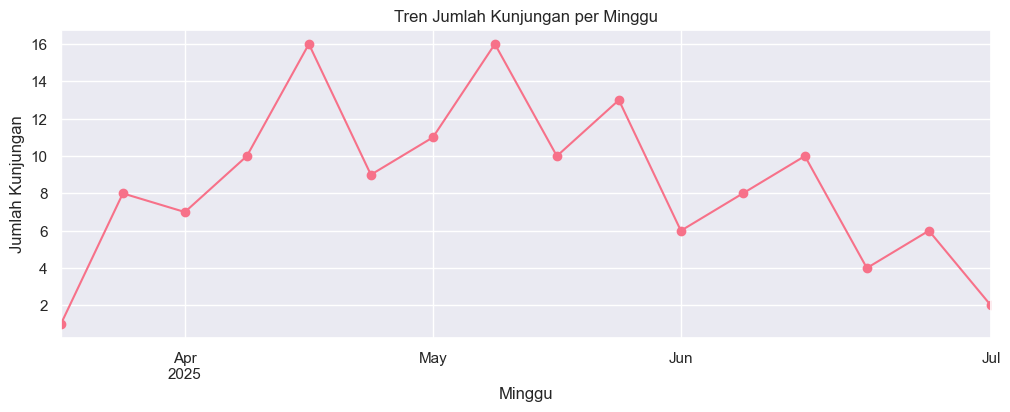

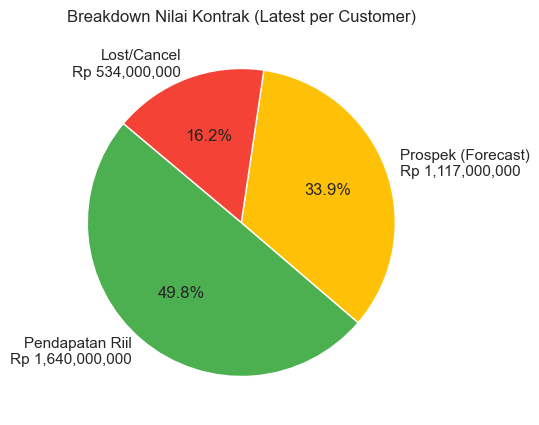

In [37]:
# Hitung metrik tingkat tinggi
overview_metrics = {
    'total_customer': df['ID_Customer'].nunique(),
    'total_kunjungan': len(df),
    'total_nilai_kontrak': df['Nilai_Kontrak'].sum()
}

# Analisis distribusi segmen

# Distribusi jumlah customer berdasarkan Status_Kontrak (gabungkan 'batal' dan 'cancel')
status_kontrak_dist = latest_contracts['Status_Kontrak'].str.lower().replace({'batal': 'cancel'}).value_counts()
status_kontrak_dist = status_kontrak_dist.rename(index={'cancel': 'Batal/Cancel', 'deal': 'Deal', 'berpotensi deal': 'Berpotensi Deal'})

plt.figure(figsize=(6,4))
status_kontrak_dist.plot(kind='pie', autopct='%1.0f%%', startangle=90, colors=['#F44336', '#4CAF50', '#FFC107'])
plt.ylabel('')
plt.title('Distribusi Customer berdasarkan Status Kontrak (Latest per Customer)')
plt.show()






segment_dist = df.groupby('Segmen')['ID_Customer'].nunique().sort_values(ascending=False)

# Analisis kunjungan per tahap
tahap_dist = df.groupby('Progress')['ID_Customer'].count().reindex([
    'Inisiasi', 'Presentasi', 'Penawaran Harga', 'Negosiasi', 'Paska Deal'
])

# Visualisasi distribusi segmen
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
segment_dist.plot(kind='bar')
plt.title('Distribusi Customer per Segmen')
plt.xticks(rotation=45)
plt.ylabel('Jumlah Customer')

# Visualisasi distribusi tahap
plt.subplot(1,2,2)
tahap_dist.plot(kind='bar')
plt.title('Distribusi Kunjungan per Tahap')
plt.xticks(rotation=45)
plt.ylabel('Jumlah Kunjungan')
plt.tight_layout()
plt.show()

# Print ringkasan metrik
print("\nRingkasan Metrik Tingkat Tinggi:")
print(f"Total Customer Aktif: {overview_metrics['total_customer']:,}")
print(f"Total Kunjungan: {overview_metrics['total_kunjungan']:,}")
print(f"Total Nilai Kontrak: Rp {overview_metrics['total_nilai_kontrak']:,.0f}")

# Tren kunjungan per minggu
weekly_visits = df.groupby(pd.Grouper(key='Tanggal', freq='W'))['ID_Customer'].count()

plt.figure(figsize=(12,4))
weekly_visits.plot(kind='line', marker='o')
plt.title('Tren Jumlah Kunjungan per Minggu')
plt.xlabel('Minggu')
plt.ylabel('Jumlah Kunjungan')
plt.grid(True)
plt.show()

# Simpan hasil analisis
# Ambil kontrak terakhir per customer
latest_contracts = df.sort_values('Tanggal').groupby('ID_Customer').last()

# Hitung nilai kontrak aktual (sudah deal & implementasi berjalan)
nilai_kontrak_aktual = latest_contracts[
    (latest_contracts['Progress'] == 'Paska Deal') &
    (latest_contracts['Status_Kontrak'].str.lower() == 'deal')
]['Nilai_Kontrak'].sum()

# Hitung nilai kontrak prospek (masih forecast)
nilai_kontrak_prospek = latest_contracts[
    (latest_contracts['Progress'] != 'Paska Deal') &
    (latest_contracts['Status_Kontrak'].str.lower() == 'berpotensi deal')
]['Nilai_Kontrak'].sum()

# Hitung nilai kontrak lost (cancel/batal)
nilai_kontrak_lost = latest_contracts[
    latest_contracts['Status_Kontrak'].str.lower().isin(['cancel', 'batal'])
]['Nilai_Kontrak'].sum()

# Total nilai kontrak (hanya latest per customer)
total_nilai_project = latest_contracts['Nilai_Kontrak'].sum()

# Persentase breakdown
persen_aktual = nilai_kontrak_aktual / total_nilai_project * 100 if total_nilai_project > 0 else 0
persen_prospek = nilai_kontrak_prospek / total_nilai_project * 100 if total_nilai_project > 0 else 0
persen_lost = nilai_kontrak_lost / total_nilai_project * 100 if total_nilai_project > 0 else 0
# Tampilkan nilai rupiah pada pie chart
labels = [
    f"Pendapatan Riil\nRp {nilai_kontrak_aktual:,.0f}",
    f"Prospek (Forecast)\nRp {nilai_kontrak_prospek:,.0f}",
    f"Lost/Cancel\nRp {nilai_kontrak_lost:,.0f}"
]
plt.figure(figsize=(7,5))
plt.pie(
    [nilai_kontrak_aktual, nilai_kontrak_prospek, nilai_kontrak_lost],
    labels=labels,
    autopct='%1.1f%%',
    colors=['#4CAF50', '#FFC107', '#F44336'],
    startangle=140
)
plt.title('Breakdown Nilai Kontrak (Latest per Customer)')
plt.show()

# Tambahkan ke overview_data
overview_data = {
    'metrics': overview_metrics,
    'segment_distribution': segment_dist,
    'tahap_distribution': tahap_dist,
    'weekly_trend': weekly_visits,
    'nilai_kontrak_breakdown': {
        'total_project': total_nilai_project,
        'pendapatan_riil': nilai_kontrak_aktual,
        'prospek': nilai_kontrak_prospek,
        'lost': nilai_kontrak_lost,
        'persen_riil': persen_aktual,
        'persen_prospek': persen_prospek,
        'persen_lost': persen_lost
    }
}

with open('overview_metrics.pkl', 'wb') as f:
    pickle.dump(overview_data, f)

## 3. Sales Funnel Analysis

Analisis ini mengevaluasi efektivitas konversi di tiap tahap penjualan:
- Funnel chart dari Inisiasi ke Paska Deal
- Tingkat konversi antar tahap
- Analisis drop-off
- Perbandingan antar segmen dan sales

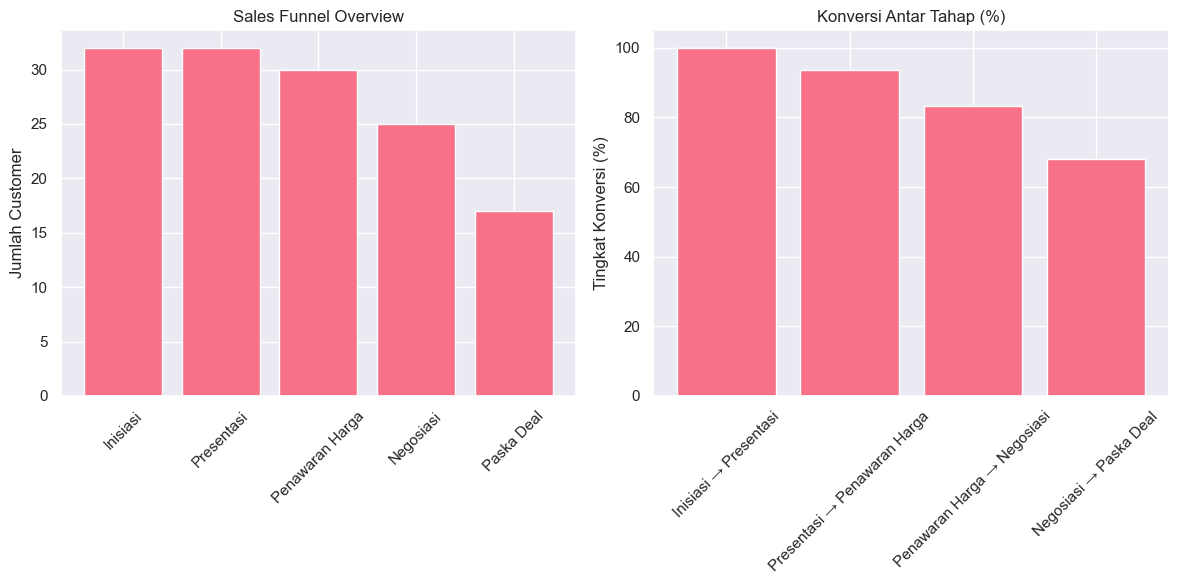

<Figure size 1500x500 with 0 Axes>

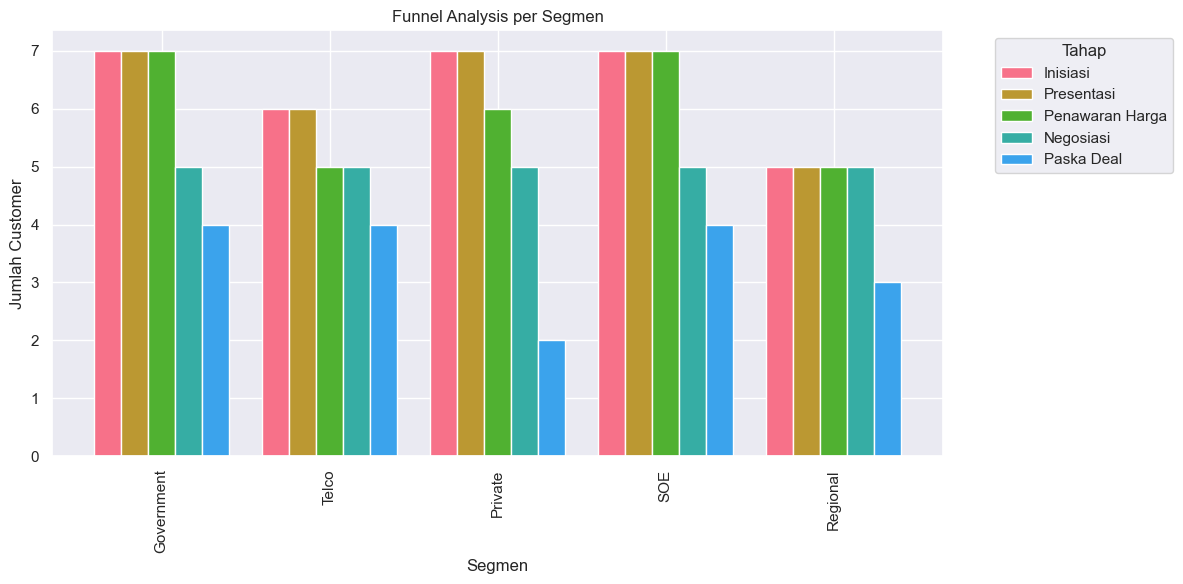


Tahap dengan drop-off terbesar: Negosiasi → Paska Deal
Jumlah customer yang drop: 8


In [38]:
# Definisikan urutan tahapan funnel
tahapan_funnel = ['Inisiasi', 'Presentasi', 'Penawaran Harga', 'Negosiasi', 'Paska Deal']

# Analisis funnel keseluruhan
funnel_overall = {}
for tahap in tahapan_funnel:
    funnel_overall[tahap] = df[df['Progress'] == tahap]['ID_Customer'].nunique()

# Hitung konversi antar tahap
konversi_tahap = {}
for i in range(len(tahapan_funnel)-1):
    tahap_current = tahapan_funnel[i]
    tahap_next = tahapan_funnel[i+1]
    if funnel_overall[tahap_current] > 0:
        konversi = (funnel_overall[tahap_next] / funnel_overall[tahap_current]) * 100
        konversi_tahap[f"{tahap_current} → {tahap_next}"] = konversi

# Visualisasi funnel
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.bar(funnel_overall.keys(), funnel_overall.values())
plt.title('Sales Funnel Overview')
plt.xticks(rotation=45)
plt.ylabel('Jumlah Customer')

# Visualisasi konversi
plt.subplot(1,2,2)
plt.bar(konversi_tahap.keys(), konversi_tahap.values())
plt.title('Konversi Antar Tahap (%)')
plt.xticks(rotation=45)
plt.ylabel('Tingkat Konversi (%)')
plt.tight_layout()
plt.show()

# Analisis funnel per segmen
funnel_segmen = {}
for segmen in df['Segmen'].unique():
    df_segmen = df[df['Segmen'] == segmen]
    funnel_segmen[segmen] = {}
    for tahap in tahapan_funnel:
        funnel_segmen[segmen][tahap] = df_segmen[df_segmen['Progress'] == tahap]['ID_Customer'].nunique()

# Visualisasi funnel per segmen
plt.figure(figsize=(15,5))
segmen_df = pd.DataFrame(funnel_segmen).T
segmen_df.plot(kind='bar', width=0.8)
plt.title('Funnel Analysis per Segmen')
plt.xlabel('Segmen')
plt.ylabel('Jumlah Customer')
plt.legend(title='Tahap', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Identifikasi tahap dengan drop-off terbesar
drop_offs = {}
for i in range(len(tahapan_funnel)-1):
    tahap_current = tahapan_funnel[i]
    tahap_next = tahapan_funnel[i+1]
    drop = funnel_overall[tahap_current] - funnel_overall[tahap_next]
    drop_offs[f"{tahap_current} → {tahap_next}"] = drop

max_drop = max(drop_offs.items(), key=lambda x: x[1])
print(f"\nTahap dengan drop-off terbesar: {max_drop[0]}")
print(f"Jumlah customer yang drop: {max_drop[1]}")

# Simpan hasil analisis
funnel_data = {
    'funnel_overall': funnel_overall,
    'konversi_tahap': konversi_tahap,
    'funnel_segmen': funnel_segmen,
    'drop_offs': drop_offs
}

with open('funnel_analysis.pkl', 'wb') as f:
    pickle.dump(funnel_data, f)

## 4. Analisis Durasi & Frekuensi Kunjungan

Analisis ini mengukur kecepatan dan konsistensi proses penjualan:
- Rata-rata durasi dari Inisiasi ke Deal
- Rata-rata jeda antar kunjungan
- Distribusi waktu closing
- Korelasi antara frekuensi kunjungan dan keberhasilan closing

Rata-rata durasi mencapai Paska Deal: 74.8 hari
Median durasi mencapai Paska Deal: 74.0 hari

Rata-rata jeda antar kunjungan: 18.7 hari
Median jeda antar kunjungan: 18.0 hari


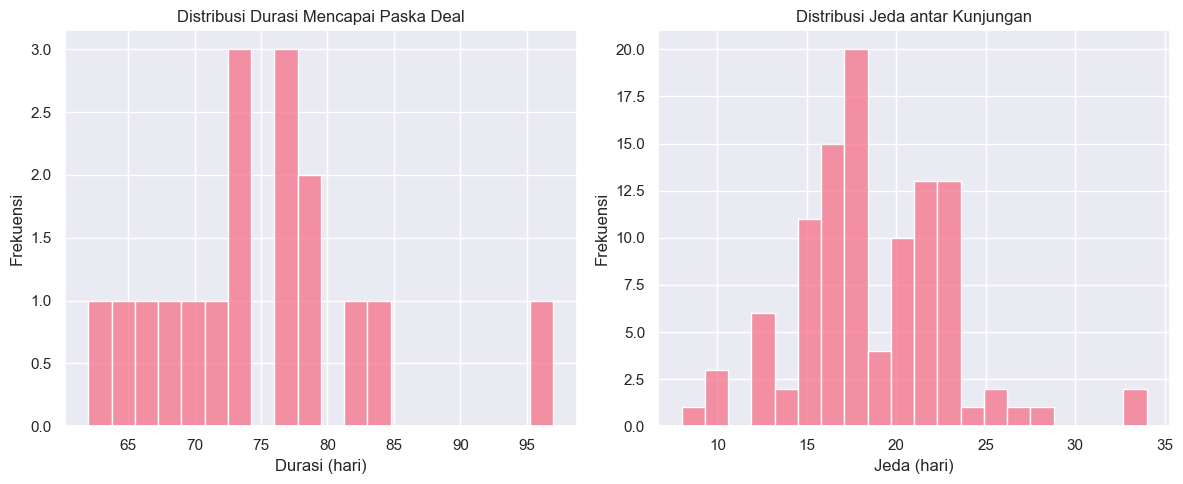


Jumlah customer yang perlu follow-up (>14 hari): 32

Analisis Jeda antar Kunjungan untuk Customer Deal:
Rata-rata jeda customer deal: 18.4 hari
Median jeda customer deal: 18.0 hari


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Analisis durasi per customer
customer_duration = df.groupby('ID_Customer').agg({
    'Tanggal': lambda x: (x.max() - x.min()).days,
    'Progress': ['first', 'last']
}).reset_index()

customer_duration.columns = ['ID_Customer', 'Durasi_Total', 'Progress_Awal', 'Progress_Akhir']

# Hitung rata-rata durasi untuk customer yang mencapai Paska Deal
deal_duration = customer_duration[customer_duration['Progress_Akhir'] == 'Paska Deal']['Durasi_Total']
print(f"Rata-rata durasi mencapai Paska Deal: {deal_duration.mean():.1f} hari")
print(f"Median durasi mencapai Paska Deal: {deal_duration.median():.1f} hari")

# Analisis jeda antar kunjungan
customer_gaps = []
for customer in df['ID_Customer'].unique():
    visits = df[df['ID_Customer'] == customer]['Tanggal'].sort_values()
    if len(visits) > 1:
        gaps = visits.diff().dt.days.dropna()
        customer_gaps.extend(gaps)

avg_gap = np.mean(customer_gaps)
median_gap = np.median(customer_gaps)
print(f"\nRata-rata jeda antar kunjungan: {avg_gap:.1f} hari")
print(f"Median jeda antar kunjungan: {median_gap:.1f} hari")

# Visualisasi distribusi durasi
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(deal_duration, bins=20)
plt.title('Distribusi Durasi Mencapai Paska Deal')
plt.xlabel('Durasi (hari)')
plt.ylabel('Frekuensi')

# Visualisasi distribusi jeda kunjungan
plt.subplot(1,2,2)
sns.histplot(customer_gaps, bins=20)
plt.title('Distribusi Jeda antar Kunjungan')
plt.xlabel('Jeda (hari)')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

# Identifikasi customer yang perlu follow-up (tidak dikunjungi > 14 hari)
last_visit = df.groupby('ID_Customer')['Tanggal'].max()
days_since_visit = (pd.Timestamp.now() - last_visit).dt.days
needs_followup = days_since_visit[days_since_visit > 14]

print(f"\nJumlah customer yang perlu follow-up (>14 hari): {len(needs_followup)}")

# Analisis jeda antar kunjungan untuk customer deal
deal_customers = customer_duration[
    customer_duration['Progress_Akhir'].str.lower() == 'paska deal'
]['ID_Customer']

deal_gaps = []
for customer in deal_customers:
    visits = df[df['ID_Customer'] == customer]['Tanggal'].sort_values()
    if len(visits) > 1:
        gaps = visits.diff().dt.days.dropna()
        deal_gaps.extend(gaps)

avg_deal_gap = np.mean(deal_gaps) if deal_gaps else np.nan
median_deal_gap = np.median(deal_gaps) if deal_gaps else np.nan

print("\nAnalisis Jeda antar Kunjungan untuk Customer Deal:")
print(f"Rata-rata jeda customer deal: {avg_deal_gap:.1f} hari")
print(f"Median jeda customer deal: {median_deal_gap:.1f} hari")

# Simpan data durasi
duration_data = {
    'deal_duration_mean': deal_duration.mean(),
    'deal_duration_median': deal_duration.median(),
    'visit_gap_mean': avg_gap,
    'visit_gap_median': median_gap,
    'deal_gap_mean': avg_deal_gap,
    'deal_gap_median': median_deal_gap,
    'needs_followup_count': len(needs_followup)
}

with open('durasi_kunjungan.pkl', 'wb') as f:
    pickle.dump(duration_data, f)


## 5. Performa Individu Sales

Analisis performa individual untuk setiap sales:
- Total kunjungan dan nilai kontrak
- Tingkat konversi dan closing rate
- Rata-rata progress customer
- Efektivitas aktivitas sales


📋 Tabel Ringkasan & Leaderboard Sales:
                Total_Kunjungan  Jumlah_Customer  Nilai_Kontrak_Aktual  \
Nama_Sales                                                               
Agus Darmawan                15                3             346000000   
Nina Anggraini               15                3             131000000   
Siti Rahayu                  17                4             427000000   
Budi Santoso                 18                4             202000000   
Dian Permata                 15                3             236000000   
Rudi Hartono                 14                3             100000000   
Maya Susanti                 11                3              35000000   
Ahmad Fauzi                  11                3             127000000   
Hendra Wijaya                11                3             160000000   
Dewi Pratiwi                 10                3                     0   

                Prospek_Nilai_Kontrak  Total_Nilai_Kontrak  \
Nama_Sale

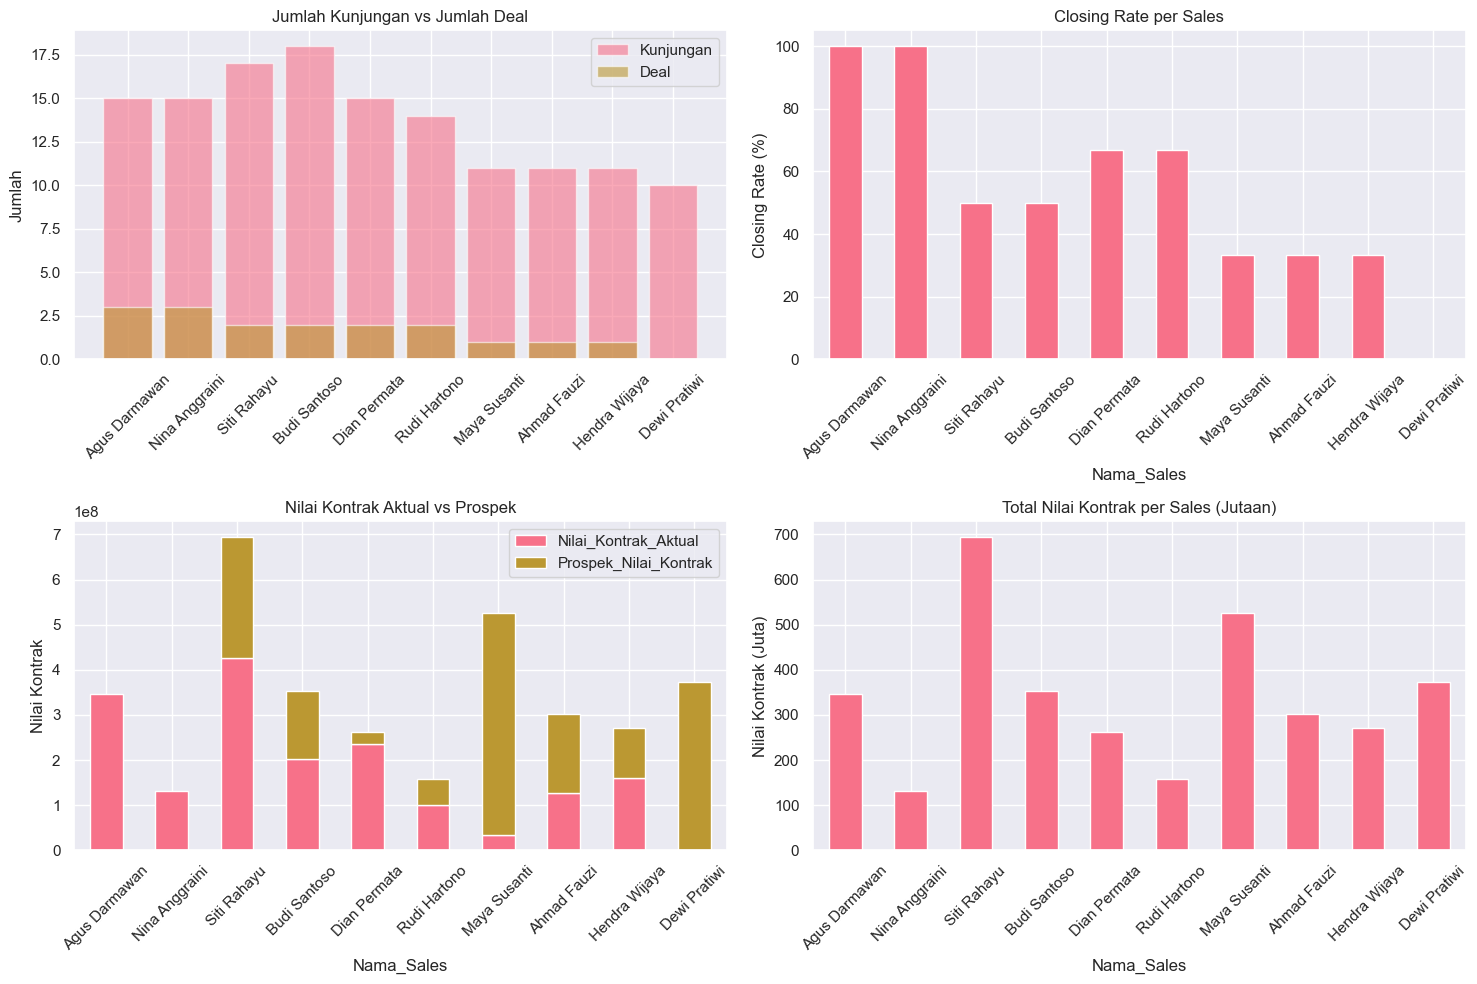

In [53]:
# ... (kode sebelumnya tetap)

# Urutkan berdasarkan jumlah deal dan total nilai kontrak
sales_performance = sales_performance.sort_values(['Jumlah_Deal', 'Total_Nilai_Kontrak'], ascending=False)

# 📊 Gabungan: Leaderboard + Ringkasan Sales
summary_cols = [
    'Total_Kunjungan',
    'Jumlah_Customer',
    'Nilai_Kontrak_Aktual',
    'Prospek_Nilai_Kontrak',
    'Total_Nilai_Kontrak',
    'Rata_Rata_Progress',
    'Jumlah_Deal',
    'Closing_Rate',
    'Efektivitas',
    'Level_Sales'
]

print("\n📋 Tabel Ringkasan & Leaderboard Sales Berdasarkan Closing Rate:")
print(sales_performance[summary_cols].round(2))

# 📈 Visualisasi (tetap seperti sebelumnya)
plt.figure(figsize=(15, 10))

# Bar Chart 1: Jumlah Kunjungan vs Deal
plt.subplot(2, 2, 1)
plt.bar(sales_performance.index, sales_performance['Total_Kunjungan'], alpha=0.6, label='Kunjungan')
plt.bar(sales_performance.index, sales_performance['Jumlah_Deal'], alpha=0.6, label='Deal')
plt.title('Jumlah Kunjungan vs Jumlah Deal')
plt.xticks(rotation=45)
plt.ylabel('Jumlah')
plt.legend()

# Bar Chart 2: Closing Rate
plt.subplot(2, 2, 2)
sales_performance['Closing_Rate'].plot(kind='bar')
plt.title('Closing Rate per Sales')
plt.xticks(rotation=45)
plt.ylabel('Closing Rate (%)')

# Bar Chart 3: Nilai Kontrak Aktual vs Prospek
plt.subplot(2, 2, 3)
sales_performance[['Nilai_Kontrak_Aktual', 'Prospek_Nilai_Kontrak']].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Nilai Kontrak Aktual vs Prospek')
plt.xticks(rotation=45)
plt.ylabel('Nilai Kontrak')


# 🔍 Identifikasi Sales yang Perlu Pendampingan
low_performers = sales_performance[
    (sales_performance['Closing_Rate'] < sales_performance['Closing_Rate'].median()) & 
    (sales_performance['Total_Kunjungan'] > sales_performance['Total_Kunjungan'].median())
]

if not low_performers.empty:
    print("\n⚠️ Sales yang memerlukan pendampingan (aktivitas tinggi, konversi rendah):")
    print(low_performers[['Total_Kunjungan', 'Closing_Rate']])

# 📤 Simpan hasil analisis
performa_data = {
    'sales_performance': sales_performance,
    'low_performers': low_performers,
    'top_performer': sales_performance.index[0]
}

with open('performa_sales.pkl', 'wb') as f:
    pickle.dump(performa_data, f)


Tabel Ringkasan & Leaderboard Sales berdasarkan Efisiensi Waktu
         Sales  Rata-rata Durasi (hari)  Rank
   Siti Rahayu                66.500000     1
  Maya Susanti                68.000000     2
  Budi Santoso                73.000000     3
Nina Anggraini                73.000000     3
 Agus Darmawan                75.333333     5
  Rudi Hartono                76.000000     6
  Dian Permata                76.500000     7
   Ahmad Fauzi                77.000000     8
 Hendra Wijaya                97.000000     9

📌 Insight:
- Sales dengan proses tercepat adalah **Siti Rahayu** dengan rata-rata durasi 66.5 hari.
- Sales ini dapat dijadikan mentor bagi sales lain.
- Pola kerja sales tercepat bisa dianalisis lebih lanjut untuk dijadikan template proses yang efisien.


C:\Users\SITI NURAFIFA(RIMA)\AppData\Local\Temp\ipykernel_4504\1654437075.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  durasi_per_customer = df_paska.groupby("ID_Customer").apply(get_duration).dropna()


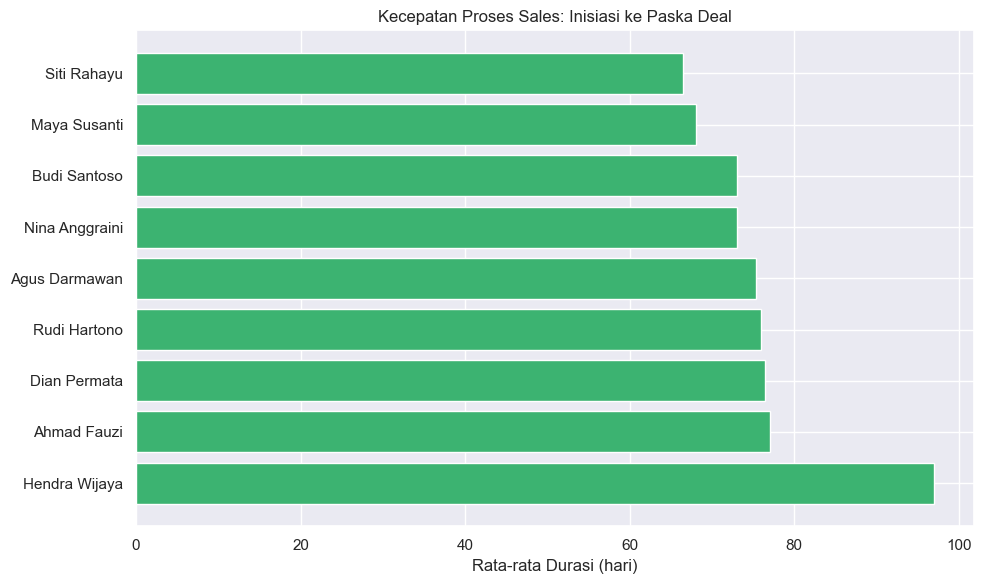

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load dataset
df = pd.read_csv("sales_visits_finalbgt_enriched.csv", parse_dates=["Tanggal"])

# 2. Filter hanya customer yang sudah sampai tahap "Paska Deal"
paska_deal_customers = df[df["Progress"] == "Paska Deal"]["ID_Customer"].unique()
df_paska = df[df["ID_Customer"].isin(paska_deal_customers)]

# 3. Urutkan berdasarkan tanggal per customer
df_paska = df_paska.sort_values(["ID_Customer", "Tanggal"])

# 4. Ambil tanggal inisiasi & paska deal untuk hitung durasi
def get_duration(group):
    inisiasi_date = group[group["Progress"] == "Inisiasi"]["Tanggal"].min()
    paska_deal_date = group[group["Progress"] == "Paska Deal"]["Tanggal"].max()
    duration = (paska_deal_date - inisiasi_date).days
    return pd.Series({
        "Nama_Sales": group["Nama_Sales"].iloc[0],
        "Durasi_Proses_Sales (hari)": duration
    })

durasi_per_customer = df_paska.groupby("ID_Customer").apply(get_duration).dropna()

# 5. Hitung rata-rata durasi per sales
durasi_per_sales = durasi_per_customer.groupby("Nama_Sales")["Durasi_Proses_Sales (hari)"].mean()

# 6. Buat leaderboard dalam DataFrame
leaderboard_df = durasi_per_sales.reset_index().rename(columns={
    "Nama_Sales": "Sales",
    "Durasi_Proses_Sales (hari)": "Rata-rata Durasi (hari)"
})
leaderboard_df["Rank"] = leaderboard_df["Rata-rata Durasi (hari)"].rank(method="min").astype(int)
leaderboard_df = leaderboard_df.sort_values("Rank").reset_index(drop=True)

# 7. Tampilkan tabel dengan judul
print("="*75)
print("Tabel Ringkasan & Leaderboard Sales berdasarkan Efisiensi Waktu")
print("="*75)
print(leaderboard_df.to_string(index=False))

# 8. Tampilkan insight
best_sales = leaderboard_df.iloc[0]["Sales"]
best_duration = leaderboard_df.iloc[0]["Rata-rata Durasi (hari)"]

print("\n📌 Insight:")
print(f"- Sales dengan proses tercepat adalah **{best_sales}** dengan rata-rata durasi {best_duration:.1f} hari.")
print("- Sales ini dapat dijadikan mentor bagi sales lain.")
print("- Pola kerja sales tercepat bisa dianalisis lebih lanjut untuk dijadikan template proses yang efisien.")

# 9. Visualisasi (opsional)
plt.figure(figsize=(10, 6))
plt.barh(leaderboard_df["Sales"], leaderboard_df["Rata-rata Durasi (hari)"], color='mediumseagreen')
plt.xlabel("Rata-rata Durasi (hari)")
plt.title("Kecepatan Proses Sales: Inisiasi ke Paska Deal")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


🏆 Leaderboard Sales Berdasarkan Ketercapaian Target (%)
 Rank     Nama_Sales  Total_Kontrak  Target_Sales  Ketercapaian (%)
    1  Agus Darmawan      346000000    2340000000         14.786325
    2   Dian Permata      360000000    3900000000          9.230769
    3    Siti Rahayu      427000000    4800000000          8.895833
    4  Hendra Wijaya      160000000    2460000000          6.504065
    5   Budi Santoso      202000000    3200000000          6.312500
    6    Ahmad Fauzi      127000000    2250000000          5.644444
    7   Rudi Hartono      100000000    2550000000          3.921569
    8 Nina Anggraini      131000000    3840000000          3.411458
    9   Maya Susanti       35000000    3750000000          0.933333

📌 Insight:
- Sales dengan ketercapaian target tertinggi adalah **Agus Darmawan**.
- Ia mencapai total kontrak sebesar 346000000 dari target 2340000000 (14.8%).
- Pola pendekatannya dapat dijadikan **benchmark** untuk meningkatkan performa tim sales lainnya.


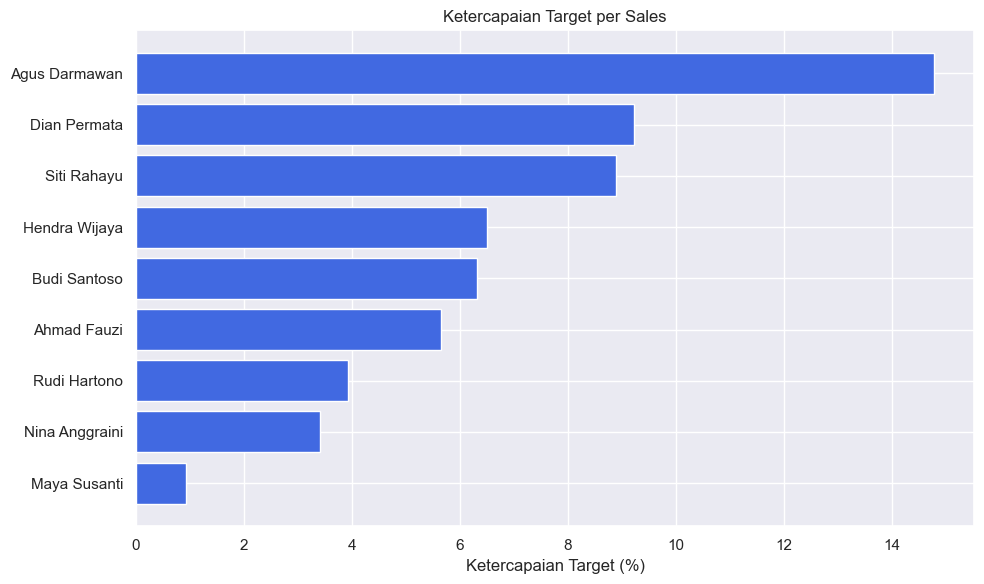

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load dataset
df = pd.read_csv("sales_visits_finalbgt_enriched.csv")

# 2. Hitung total nilai kontrak per sales (untuk customer yang sudah deal)
kontrak_per_sales = df[df["Progress"] == "Paska Deal"].groupby("Nama_Sales")["Nilai_Kontrak"].sum().reset_index()
kontrak_per_sales.rename(columns={"Nilai_Kontrak": "Total_Kontrak"}, inplace=True)

# 3. Hitung target sales unik berdasarkan kombinasi Nama_Sales dan ID_Cust (hindari duplikasi)
target_unique = df[["Nama_Sales", "ID_Customer", "Target_Sales"]].drop_duplicates(subset=["Nama_Sales", "ID_Customer"])

# 4. Hitung total target per sales
target_per_sales = target_unique.groupby("Nama_Sales")["Target_Sales"].sum().reset_index()

# 5. Gabungkan dengan nilai kontrak untuk hitung ketercapaian
df_target = pd.merge(kontrak_per_sales, target_per_sales, on="Nama_Sales", how="left")

# 6. Hitung ketercapaian (%)
df_target["Ketercapaian (%)"] = (df_target["Total_Kontrak"] / df_target["Target_Sales"]) * 100

# 7. Buat leaderboard
df_target["Rank"] = df_target["Ketercapaian (%)"].rank(method="min", ascending=False).astype(int)
df_target = df_target.sort_values("Rank").reset_index(drop=True)

# 8. Tampilkan leaderboard
print("="*85)
print("🏆 Leaderboard Sales Berdasarkan Ketercapaian Target (%)")
print("="*85)
print(df_target[["Rank", "Nama_Sales", "Total_Kontrak", "Target_Sales", "Ketercapaian (%)"]].to_string(index=False))

# 9. Insight
if not df_target.empty:
    top_sales = df_target.iloc[0]
    print("\n📌 Insight:")
    print(f"- Sales dengan ketercapaian target tertinggi adalah **{top_sales['Nama_Sales']}**.")
    print(f"- Ia mencapai total kontrak sebesar {top_sales['Total_Kontrak']:.0f} dari target {top_sales['Target_Sales']:.0f} ({top_sales['Ketercapaian (%)']:.1f}%).")
    print("- Pola pendekatannya dapat dijadikan **benchmark** untuk meningkatkan performa tim sales lainnya.")

# 10. Visualisasi Ketercapaian Target
plt.figure(figsize=(10, 6))
plt.barh(df_target["Nama_Sales"], df_target["Ketercapaian (%)"], color="royalblue")
plt.xlabel("Ketercapaian Target (%)")
plt.title("Ketercapaian Target per Sales")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 6. Detail Profil Sales

Analisis mendalam untuk setiap sales meliputi:
- Timeline dan pola kunjungan
- Distribusi jenis aktivitas
- Pencapaian tahapan tertinggi
- Catatan kunjungan yang efektif

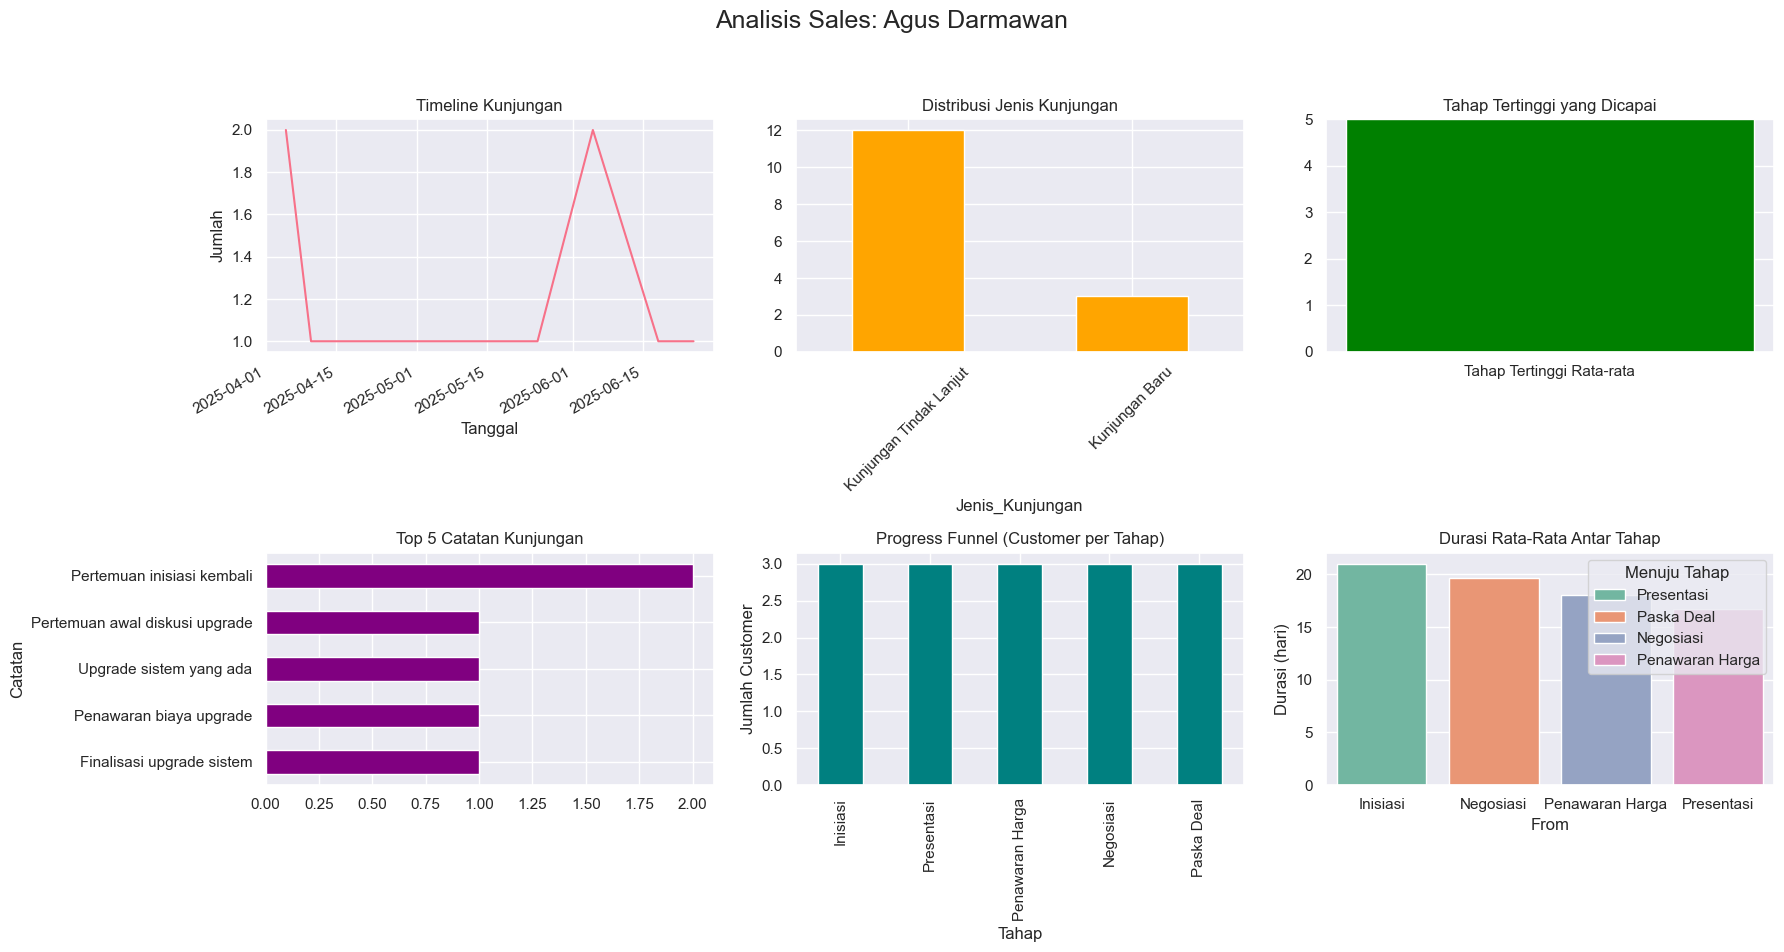


🧠 Insight untuk Agus Darmawan:
- Rata-rata tahap tertinggi per customer: 5.00
- Pola penyusutan funnel:
   Inisiasi → Presentasi: 3/3 customer
   Presentasi → Penawaran Harga: 3/3 customer
   Penawaran Harga → Negosiasi: 3/3 customer
   Negosiasi → Paska Deal: 3/3 customer
- Transisi paling lama rata-rata: Inisiasi → Presentasi (21.0 hari)
- Catatan paling sering muncul: "Pertemuan inisiasi kembali"
- Catatan efektif saat Deal: "Monitoring hasil upgrade"

🎯 Improvement untuk Agus Darmawan:
- Bangun template kunjungan berdasarkan urutan funnel terbanyak: ['Inisiasi', 'Presentasi', 'Penawaran Harga', 'Negosiasi', 'Paska Deal']
- Percepat proses dari Inisiasi ke Presentasi agar mengurangi friksi konversi.
- Perkuat penggunaan catatan seperti: "Monitoring hasil upgrade"


In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

# Pastikan kolom Tanggal dalam format datetime
df['Tanggal'] = pd.to_datetime(df['Tanggal'], dayfirst=True)

# Mapping progres ke skor
progress_order = ['Inisiasi', 'Presentasi', 'Penawaran Harga', 'Negosiasi', 'Paska Deal']
progress_score_mapping = {p: i+1 for i, p in enumerate(progress_order)}
df['Progress_Score'] = df['Progress'].map(progress_score_mapping)

# Fungsi analisis individu
def analyze_individual_sales(sales_name):
    sales_df = df[df['Nama_Sales'] == sales_name].sort_values(['ID_Customer', 'Tanggal'])

    # Timeline kunjungan
    timeline = sales_df.groupby('Tanggal').size()

    # Distribusi jenis kunjungan
    distrib_jenis = sales_df['Jenis_Kunjungan'].value_counts()

    # Tahap tertinggi dicapai rata-rata per customer
    max_stage = sales_df.groupby('ID_Customer')['Progress_Score'].max().mean()

    # Catatan paling sering muncul
    top_notes = sales_df['Catatan'].value_counts().head(5)

    # POLA FUNNEL - menghitung berapa banyak customer yang pernah sampai setiap tahap
    funnel_data = {}
    for stage in progress_order:
        cust_count = sales_df[sales_df['Progress'] == stage]['ID_Customer'].nunique()
        funnel_data[stage] = cust_count
    funnel_series = pd.Series(funnel_data)

    # DURASI ANTAR TAHAP
    stage_durations = []
    for cust_id, group in sales_df.groupby('ID_Customer'):
        group = group.sort_values('Tanggal')
        stage_dates = {}
        for _, row in group.iterrows():
            stage = row['Progress']
            if stage not in stage_dates:
                stage_dates[stage] = row['Tanggal']
        stage_pairs = zip(progress_order[:-1], progress_order[1:])
        for s1, s2 in stage_pairs:
            if s1 in stage_dates and s2 in stage_dates:
                delta = (stage_dates[s2] - stage_dates[s1]).days
                if delta >= 0:
                    stage_durations.append({'From': s1, 'To': s2, 'Days': delta})

    # Rata-rata durasi antar tahap
    durasi_df = pd.DataFrame(stage_durations)
    avg_durasi = durasi_df.groupby(['From', 'To'])['Days'].mean().reset_index()

    # --- PLOTTING ---
    plt.figure(figsize=(18, 10))
    plt.suptitle(f"Analisis Sales: {sales_name}", fontsize=18)

    # Timeline
    plt.subplot(2, 3, 1)
    timeline.plot()
    plt.title('Timeline Kunjungan')
    plt.xlabel('Tanggal')
    plt.ylabel('Jumlah')

    # Jenis kunjungan
    plt.subplot(2, 3, 2)
    distrib_jenis.plot(kind='bar', color='orange')
    plt.title('Distribusi Jenis Kunjungan')
    plt.xticks(rotation=45)

    # Tahap tertinggi rata-rata
    plt.subplot(2, 3, 3)
    plt.bar(['Tahap Tertinggi Rata-rata'], [max_stage], color='green')
    plt.title('Tahap Tertinggi yang Dicapai')
    plt.ylim(0, 5)

    # Catatan populer
    plt.subplot(2, 3, 4)
    top_notes.plot(kind='barh', color='purple')
    plt.title('Top 5 Catatan Kunjungan')
    plt.gca().invert_yaxis()

    # Funnel: semua customer yang pernah mencapai tahap tertentu
    plt.subplot(2, 3, 5)
    funnel_series[progress_order].plot(kind='bar', color='teal')
    plt.title('Progress Funnel (Customer per Tahap)')
    plt.xlabel('Tahap')
    plt.ylabel('Jumlah Customer')

    # Durasi antar tahap visual
    plt.subplot(2, 3, 6)
    if not avg_durasi.empty:
        sns.barplot(data=avg_durasi, x='From', y='Days', hue='To', palette='Set2')
        plt.title('Durasi Rata-Rata Antar Tahap')
        plt.ylabel('Durasi (hari)')
        plt.legend(title='Menuju Tahap')
    else:
        plt.text(0.5, 0.5, 'Tidak cukup data durasi antar tahap', ha='center', va='center')
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Insight
    print(f"\n🧠 Insight untuk {sales_name}:")
    print(f"- Rata-rata tahap tertinggi per customer: {max_stage:.2f}")
    penyusutan = [f"{progress_order[i]} → {progress_order[i+1]}: {funnel_series[progress_order[i+1]]}/{funnel_series[progress_order[i]]} customer"
                  for i in range(len(progress_order)-1) if funnel_series[progress_order[i]] > 0]
    print("- Pola penyusutan funnel:")
    for line in penyusutan:
        print(f"  ", line)

    if not durasi_df.empty:
        slowest = avg_durasi.sort_values('Days', ascending=False).iloc[0]
        print(f"- Transisi paling lama rata-rata: {slowest['From']} → {slowest['To']} ({slowest['Days']:.1f} hari)")

    top_catatan = top_notes.idxmax()
    print(f"- Catatan paling sering muncul: \"{top_catatan}\"")

    deal_notes = sales_df[sales_df['Status_Kontrak'] == 'Deal']['Catatan'].value_counts()
    if not deal_notes.empty:
        catatan_efektif = deal_notes.idxmax()
        print(f"- Catatan efektif saat Deal: \"{catatan_efektif}\"")

    # Improvement
    print(f"\n🎯 Improvement untuk {sales_name}:")
    print("- Bangun template kunjungan berdasarkan urutan funnel terbanyak:", list(funnel_series[funnel_series > 0].index))
    if not durasi_df.empty:
        print("- Percepat proses dari", slowest['From'], "ke", slowest['To'], "agar mengurangi friksi konversi.")
    print("- Perkuat penggunaan catatan seperti:", f"\"{catatan_efektif if not deal_notes.empty else top_catatan}\"")

# Contoh penggunaan
analyze_individual_sales("Agus Darmawan")
